In [11]:
import import_ipynb
import model_nt
import torch
import numpy as np

model = model_nt.NewsTechLSTM()
model.load_state_dict(torch.load("best_news_tech_model.pt"))
model.eval()

NewsTechLSTM(
  (conv1): Conv1d(100, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (news_lstm): LSTM(64, 128, batch_first=True)
  (tech_lstm): LSTM(7, 64, batch_first=True)
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

In [12]:
import layers_nt
import yfinance as yf
import pandas as pd

technical_indicators = layers_nt.calculate_technical_indicator(start_date='2014-01-01', end_date='2014-12-31')
trading_days = pd.to_datetime(technical_indicators['Date']).dt.tz_localize(None).dt.date
daily_news_trading_days = layers_nt.calculate_embedding_layer('test2014.csv',trading_days)

merged = technical_indicators
merged['sentence_vector'] = daily_news_trading_days['sentence_vector']

[*********************100%***********************]  1 of 1 completed


In [13]:
initial_capital = 10000
buy_hold_capital = [initial_capital]
model_capital = [initial_capital]

capital = initial_capital
in_position = False  # Whether we "buy" based on model

lookback = 5

for i in range(lookback, len(merged) - 1):
    # Prepare input sequences
    news_seq = np.stack(merged['sentence_vector'].iloc[i-lookback:i].values)
    tech_seq = merged[['Stochastic_%K', 'Williams_%R', 'Stochastic_%D',
                       'AD_Oscillator', 'Momentum', 'Disparity', 'ROC']].iloc[i-lookback:i].values

    news_tensor = torch.tensor(news_seq[np.newaxis, ...], dtype=torch.float32)
    tech_tensor = torch.tensor(tech_seq[np.newaxis, ...], dtype=torch.float32)

    # Predict movement for the next day
    with torch.no_grad():
        out = model(news_tensor, tech_tensor)
        pred = torch.argmax(out, dim=1).item()  # 1 = up, 0 = down

    today_close = merged['Close'].iloc[i]
    next_close = merged['Close'].iloc[i + 1]
    pct_change = (next_close - today_close) / today_close

    # Update model strategy capital
    if pred == 1:
        capital = capital * (1 + pct_change)
    elif pred == 0:  # model says down: short!
        capital = capital * (1 - pct_change)  # "shorting" the market
    # If pred == 0, we stay in cash, capital remains the same
    model_capital.append(capital)

    # Buy & hold capital (always fully invested)
    buy_hold_capital.append(buy_hold_capital[-1] * (1 + pct_change))

# Final results
final_model_cap = model_capital[-1]
final_bh_cap = buy_hold_capital[-1]

print(f"\nFinal Capital (Model Strategy): ${final_model_cap['^GSPC']:.2f}")
print(f"Final Capital (Buy & Hold): ${final_bh_cap['^GSPC']:.2f}")


Final Capital (Model Strategy): $11307.07
Final Capital (Buy & Hold): $11317.75


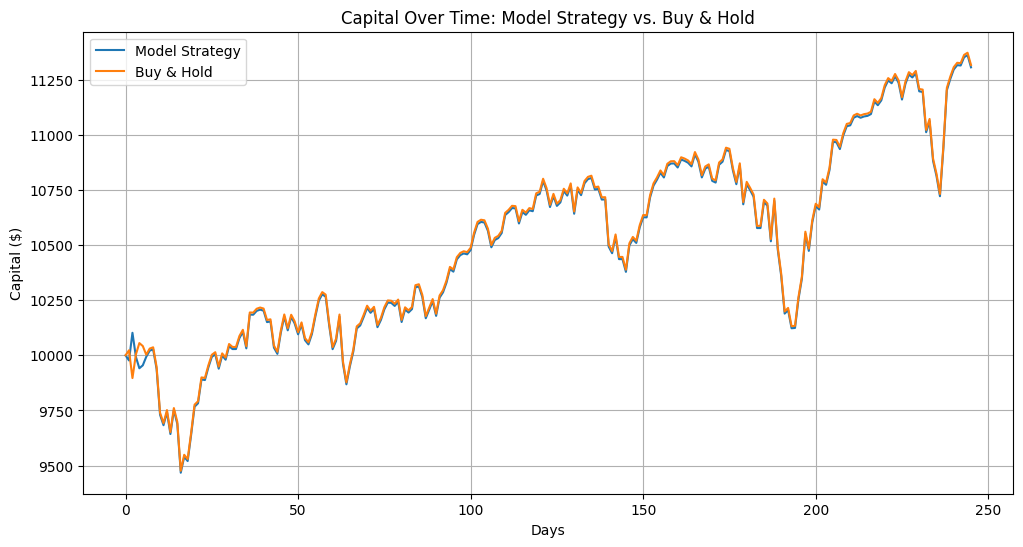

In [14]:
import matplotlib.pyplot as plt

model_capital = [x['^GSPC'] if isinstance(x, pd.Series) else x for x in model_capital]
buy_hold_capital = [x['^GSPC'] if isinstance(x, pd.Series) else x for x in buy_hold_capital]
plt.figure(figsize=(12,6))
plt.plot(model_capital, label='Model Strategy')
plt.plot(buy_hold_capital, label='Buy & Hold')
plt.xlabel('Days')
plt.ylabel('Capital ($)')
plt.title('Capital Over Time: Model Strategy vs. Buy & Hold')
plt.legend()
plt.grid()
plt.show()

In [15]:
model_capital

[10000,
 9976.933131916066,
 10102.405203062795,
 9993.117668793755,
 9941.491343203472,
 9954.8837280455,
 9993.659736008292,
 10021.37966963014,
 10027.140612273473,
 9938.003576319396,
 9730.543293783547,
 9683.09430448484,
 9742.554822703842,
 9643.090817701797,
 9751.73995341377,
 9688.69203258363,
 9467.48059293322,
 9539.822454169649,
 9520.473568956297,
 9638.906288708187,
 9767.121929026238,
 9782.448836316766,
 9890.663396717051,
 9888.000213051228,
 9945.449742308816,
 9993.279565544788,
 10004.856519153394,
 9939.579989969121,
 9999.530151821747,
 9980.343817679179,
 10042.087349100495,
 10028.553811378655,
 10028.77143077138,
 10078.394623576041,
 10106.439659339456,
 10031.869189748892,
 10185.032770326603,
 10184.489385318553,
 10201.990496115035,
 10207.480077991224,
 10202.751500515807,
 10150.89969935701,
 10153.997458334521,
 10035.184568119123,
 10006.867508114805,
 10103.069876121037,
 10176.010190687453,
 10113.614464561726,
 10174.705801278633,
 10144.86673247277